In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import CLIPProcessor, CLIPModel
from torchvision import datasets, transforms
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

class ContrastPairDataset:
    def __init__(self, root="./data", split='train'):
        self.dataset = datasets.CIFAR10(root=root, train=(split=='train'), download=True)
        self.classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                       'dog', 'frog', 'horse', 'ship', 'truck']

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def create_text_pair(self, true_label):
        true_class = self.classes[true_label]
        false_class = random.choice([c for c in self.classes if c != true_class])

        true_text = f"This is a photo of a {true_class}"
        false_text = f"This is a photo of a {false_class}"

        return true_text, false_text

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        true_text, false_text = self.create_text_pair(label)

        if isinstance(image, Image.Image):
            image = self.transform(image)
        else:
            image = transforms.Resize((224, 224))(image)

        return {
            'image': image,
            'true_text': true_text,
            'false_text': false_text,
            'label': label
        }

    def __len__(self):
        return len(self.dataset)

class CCSProbe(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.projection = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.projection(x))

class CLIPCCS:
    def __init__(self, model_name="openai/clip-vit-base-patch32"):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {self.device}")

        self.model = CLIPModel.from_pretrained(model_name).to(self.device)
        self.processor = CLIPProcessor.from_pretrained(model_name)
        self.model.eval()

        input_dim = self.model.text_model.config.hidden_size
        print(f"Probe input dimension: {input_dim}")
        self.probe = CCSProbe(input_dim).to(self.device)

    def get_features(self, batch):
        images = batch['image'].to(self.device)
        true_texts = batch['true_text']
        false_texts = batch['false_text']

        true_inputs = self.processor(
            images=images,
            text=true_texts,
            return_tensors="pt",
            padding=True,
            do_rescale=False
        )

        false_inputs = self.processor(
            images=images,
            text=false_texts,
            return_tensors="pt",
            padding=True,
            do_rescale=False
        )

        true_inputs = {k: v.to(self.device) for k, v in true_inputs.items()}
        false_inputs = {k: v.to(self.device) for k, v in false_inputs.items()}

        with torch.no_grad():
            image_features = self.model.get_image_features(true_inputs['pixel_values'])
            true_text_features = self.model.get_text_features(
                input_ids=true_inputs['input_ids'],
                attention_mask=true_inputs['attention_mask']
            )
            false_text_features = self.model.get_text_features(
                input_ids=false_inputs['input_ids'],
                attention_mask=false_inputs['attention_mask']
            )

            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            true_text_features = true_text_features / true_text_features.norm(dim=-1, keepdim=True)
            false_text_features = false_text_features / false_text_features.norm(dim=-1, keepdim=True)

            text_features = torch.stack([true_text_features, false_text_features], dim=1)

        return image_features, text_features

    def train_step(self, batch_features):
        img_features, text_features = batch_features

        true_text_features = text_features[:, 0]
        false_text_features = text_features[:, 1]

        pos_score = self.probe(true_text_features)
        neg_score = self.probe(false_text_features)

        consistency_loss = ((pos_score - (1 - neg_score))**2).mean()
        confidence_loss = torch.min(pos_score, neg_score).pow(2).mean()

        return consistency_loss + confidence_loss

    def train(self, dataset, batch_size=32, num_epochs=10):
        dataloader = torch.utils.data.DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=2,
            collate_fn=self._collate_fn
        )

        optimizer = optim.Adam(self.probe.parameters(), lr=0.001)
        losses = []

        for epoch in range(num_epochs):
            epoch_loss = 0
            for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
                batch_features = self.get_features(batch)
                loss = self.train_step(batch_features)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            avg_epoch_loss = epoch_loss / len(dataloader)
            losses.append(avg_epoch_loss)
            print(f"Epoch {epoch+1}, Loss: {avg_epoch_loss:.4f}")

        return losses

    @staticmethod
    def _collate_fn(batch):
        return {
            'image': torch.stack([item['image'] for item in batch]),
            'true_text': [item['true_text'] for item in batch],
            'false_text': [item['false_text'] for item in batch],
            'label': torch.tensor([item['label'] for item in batch])
        }

    def analyze_learned_direction(self, dataset, num_samples=100):
        dataloader = torch.utils.data.DataLoader(
            dataset,
            batch_size=num_samples,
            shuffle=True,
            collate_fn=self._collate_fn
        )

        batch = next(iter(dataloader))
        img_features, text_features = self.get_features(batch)

        with torch.no_grad():
            true_scores = self.probe(text_features[:, 0])
            false_scores = self.probe(text_features[:, 1])

            true_scores = true_scores.cpu().numpy()
            false_scores = false_scores.cpu().numpy()

        return true_scores, false_scores

def visualize_results(losses, true_scores, false_scores):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.hist(true_scores, alpha=0.5, label='True statements', bins=20)
    plt.hist(false_scores, alpha=0.5, label='False statements', bins=20)
    plt.title('Distribution of Scores')
    plt.xlabel('Score')
    plt.ylabel('Count')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    dataset = ContrastPairDataset(root="./data", split='train')
    print(f"Dataset size: {len(dataset)}")

    clip_ccs = CLIPCCS()

    losses = clip_ccs.train(dataset, batch_size=32, num_epochs=10)

    true_scores, false_scores = clip_ccs.analyze_learned_direction(dataset)

    visualize_results(losses, true_scores, false_scores)

    sample_idx = random.randint(0, len(dataset)-1)
    sample = dataset[sample_idx]

    print("\nExample predictions:")
    print(f"Image class: {dataset.classes[sample['label']]}")
    print(f"True statement: {sample['true_text']}")
    print(f"False statement: {sample['false_text']}")

    with torch.no_grad():
        features = clip_ccs.get_features({k: v.unsqueeze(0) if isinstance(v, torch.Tensor) else [v]
                                        for k, v in sample.items()})
        true_score = clip_ccs.probe(features[1][:, 0])
        false_score = clip_ccs.probe(features[1][:, 1])

        print(f"\nProbe scores:")
        print(f"True statement score: {true_score.item():.3f}")
        print(f"False statement score: {false_score.item():.3f}")


Files already downloaded and verified
Dataset size: 50000
Using device: cuda
Probe input dimension: 512


Epoch 1/10:  37%|███▋      | 586/1563 [04:18<07:10,  2.27it/s]


KeyboardInterrupt: 

Files already downloaded and verified
Dataset size: 1000
Using device: cuda
Probe input dimension: 512


Epoch 1/5: 100%|██████████| 63/63 [00:09<00:00,  6.55it/s]


Epoch 1, Loss: 3.9436


Epoch 2/5: 100%|██████████| 63/63 [00:09<00:00,  6.71it/s]


Epoch 2, Loss: 3.7904


Epoch 3/5: 100%|██████████| 63/63 [00:08<00:00,  7.23it/s]


Epoch 3, Loss: 3.7985


Epoch 4/5: 100%|██████████| 63/63 [00:09<00:00,  6.73it/s]


Epoch 4, Loss: 3.7914


Epoch 5/5: 100%|██████████| 63/63 [00:09<00:00,  6.79it/s]


Epoch 5, Loss: 3.7830


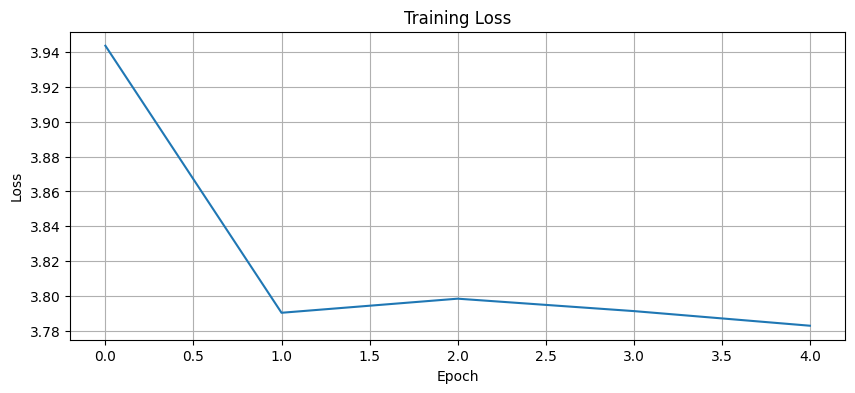


Testing on 5 random examples:

Image class: airplane
True statement: This is a photo of a airplane
False statement: This is a photo of a dog
True statement score: 0.487
False statement score: 0.526

Image class: dog
True statement: This is a photo of a dog
False statement: This is a photo of a ship
True statement score: 0.449
False statement score: 0.435

Image class: bird
True statement: This is a photo of a bird
False statement: This is a photo of a automobile
True statement score: 0.485
False statement score: 0.542

Image class: airplane
True statement: This is a photo of a airplane
False statement: This is a photo of a bird
True statement score: 0.454
False statement score: 0.463

Image class: frog
True statement: This is a photo of a frog
False statement: This is a photo of a bird
True statement score: 0.488
False statement score: 0.428


In [9]:

import torch
import torch.nn as nn
import torch.optim as optim
from transformers import CLIPProcessor, CLIPModel
from torchvision import datasets, transforms
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

# Dataset class remains the same as before
class ContrastPairDataset:
    def __init__(self, root="./data", split='train', max_samples=1000):
        self.dataset = datasets.CIFAR10(root=root, train=(split=='train'), download=True)
        self.classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                       'dog', 'frog', 'horse', 'ship', 'truck']

        total_size = len(self.dataset)
        self.indices = random.sample(range(total_size), min(max_samples, total_size))

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def create_text_pair(self, true_label):
        true_class = self.classes[true_label]
        false_class = random.choice([c for c in self.classes if c != true_class])

        true_text = f"This is a photo of a {true_class}"
        false_text = f"This is a photo of a {false_class}"

        return true_text, false_text

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        image, label = self.dataset[real_idx]
        true_text, false_text = self.create_text_pair(label)

        if isinstance(image, Image.Image):
            image = self.transform(image)
        else:
            image = transforms.Resize((224, 224))(image)

        return {
            'image': image,
            'true_text': true_text,
            'false_text': false_text,
            'label': label
        }

    def __len__(self):
        return len(self.indices)

# Improved probe with more complex architecture
class ImprovedCCSProbe(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1)
        )

        # Initialize weights for better training
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return torch.sigmoid(self.net(x))

class CLIPCCS:
    def __init__(self, model_name="openai/clip-vit-base-patch32"):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {self.device}")

        self.model = CLIPModel.from_pretrained(model_name).to(self.device)
        self.processor = CLIPProcessor.from_pretrained(model_name)
        self.model.eval()

        input_dim = self.model.text_model.config.hidden_size
        print(f"Probe input dimension: {input_dim}")
        self.probe = ImprovedCCSProbe(input_dim).to(self.device)

    def get_features(self, batch):
        images = batch['image'].to(self.device)
        true_texts = batch['true_text']
        false_texts = batch['false_text']

        inputs = self.processor(
            images=images,
            text=true_texts + false_texts,
            return_tensors="pt",
            padding=True,
            do_rescale=False
        )

        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            batch_size = len(true_texts)
            image_features = self.model.get_image_features(inputs['pixel_values'])

            all_text_features = self.model.get_text_features(
                input_ids=inputs['input_ids'],
                attention_mask=inputs['attention_mask']
            )

            true_text_features = all_text_features[:batch_size]
            false_text_features = all_text_features[batch_size:]

            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            true_text_features = true_text_features / true_text_features.norm(dim=-1, keepdim=True)
            false_text_features = false_text_features / false_text_features.norm(dim=-1, keepdim=True)

            text_features = torch.stack([true_text_features, false_text_features], dim=1)

        return image_features, text_features

    def compute_improved_loss(self, pos_score, neg_score, margin=0.5, alpha=2.0):
        """
        Fixed loss function that properly encourages:
        - High scores (near 1.0) for true statements
        - Low scores (near 0.0) for false statements
        """
        # We want pos_score to be high and neg_score to be low
        true_target = torch.ones_like(pos_score)
        false_target = torch.zeros_like(neg_score)

        # Direct binary cross entropy for pushing scores to correct extremes
        true_loss = -torch.log(pos_score + 1e-6)  # Push true scores toward 1
        false_loss = -torch.log(1 - neg_score + 1e-6)  # Push false scores toward 0

        # Separation loss
        separation_loss = torch.relu(margin - (pos_score - neg_score))

        # Combined loss
        total_loss = (true_loss.mean() + false_loss.mean() + separation_loss.mean()) * alpha

        return total_loss

    def train_step(self, batch_features):
        img_features, text_features = batch_features

        true_text_features = text_features[:, 0]  # True statement features
        false_text_features = text_features[:, 1]  # False statement features

        true_score = self.probe(true_text_features)   # Should be high (near 1)
        false_score = self.probe(false_text_features) # Should be low (near 0)

        return self.compute_improved_loss(true_score, false_score)

    def train_step(self, batch_features):
        img_features, text_features = batch_features

        true_text_features = text_features[:, 0]
        false_text_features = text_features[:, 1]

        pos_score = self.probe(true_text_features)
        neg_score = self.probe(false_text_features)

        return self.compute_improved_loss(pos_score, neg_score)

    def train(self, dataset, batch_size=64, num_epochs=5):
        dataloader = torch.utils.data.DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,
            collate_fn=self._collate_fn
        )

        # Use AdamW with weight decay and learning rate scheduler
        optimizer = optim.AdamW(self.probe.parameters(), lr=0.001, weight_decay=0.01)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

        losses = []

        for epoch in range(num_epochs):
            epoch_loss = 0
            for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
                batch_features = self.get_features(batch)
                loss = self.train_step(batch_features)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            scheduler.step()
            avg_epoch_loss = epoch_loss / len(dataloader)
            losses.append(avg_epoch_loss)
            print(f"Epoch {epoch+1}, Loss: {avg_epoch_loss:.4f}")

        return losses

    @staticmethod
    def _collate_fn(batch):
        return {
            'image': torch.stack([item['image'] for item in batch]),
            'true_text': [item['true_text'] for item in batch],
            'false_text': [item['false_text'] for item in batch],
            'label': torch.tensor([item['label'] for item in batch])
        }

def visualize_results(losses):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 1, 1)
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    dataset = ContrastPairDataset(root="./data", split='train', max_samples=1000)
    print(f"Dataset size: {len(dataset)}")

    clip_ccs = CLIPCCS()
    losses = clip_ccs.train(dataset, batch_size=16, num_epochs=5)

    visualize_results(losses)

    # Test on multiple examples
    print("\nTesting on 5 random examples:")
    for _ in range(5):
        sample_idx = random.randint(0, len(dataset)-1)
        sample = dataset[sample_idx]

        print(f"\nImage class: {dataset.classes[sample['label']]}")
        print(f"True statement: {sample['true_text']}")
        print(f"False statement: {sample['false_text']}")

        with torch.no_grad():
            features = clip_ccs.get_features({k: v.unsqueeze(0) if isinstance(v, torch.Tensor) else [v]
                                            for k, v in sample.items()})
            true_score = clip_ccs.probe(features[1][:, 0])
            false_score = clip_ccs.probe(features[1][:, 1])

            print(f"True statement score: {true_score.item():.3f}")
            print(f"False statement score: {false_score.item():.3f}")

Files already downloaded and verified
Dataset size: 1000
Using device: cuda
Probe input dimension: 512


Epoch 1/5: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


Epoch 1, Loss: 11.1955


Epoch 2/5: 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]


Epoch 2, Loss: 6.9372


Epoch 3/5: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


Epoch 3, Loss: 6.4108


Epoch 4/5: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


Epoch 4, Loss: 6.2357


Epoch 5/5: 100%|██████████| 16/16 [00:09<00:00,  1.77it/s]


Epoch 5, Loss: 6.2823


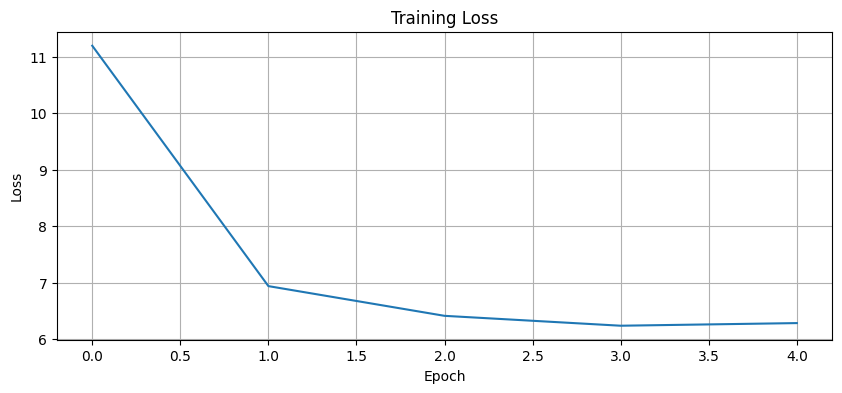


Testing on 10 random examples:

Image class: dog
True statement: This is a photo of a dog
False statement: This is a photo of a truck
True statement score: 0.943
False statement score: 0.085
Score difference: 0.858

Image class: airplane
True statement: This is a photo of a airplane
False statement: This is a photo of a truck
True statement score: 0.969
False statement score: 0.656
Score difference: 0.313

Image class: truck
True statement: This is a photo of a truck
False statement: This is a photo of a deer
True statement score: 0.482
False statement score: 0.360
Score difference: 0.122

Image class: cat
True statement: This is a photo of a cat
False statement: This is a photo of a dog
True statement score: 0.262
False statement score: 0.266
Score difference: -0.004

Image class: dog
True statement: This is a photo of a dog
False statement: This is a photo of a cat
True statement score: 0.923
False statement score: 0.345
Score difference: 0.578

Image class: automobile
True statemen

In [10]:

import torch
import torch.nn as nn
import torch.optim as optim
from transformers import CLIPProcessor, CLIPModel
from torchvision import datasets, transforms
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

class ContrastPairDataset:
    def __init__(self, root="./data", split='train', max_samples=1000):
        self.dataset = datasets.CIFAR10(root=root, train=(split=='train'), download=True)
        self.classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                       'dog', 'frog', 'horse', 'ship', 'truck']

        total_size = len(self.dataset)
        self.indices = random.sample(range(total_size), min(max_samples, total_size))

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def create_text_pair(self, true_label):
        true_class = self.classes[true_label]
        false_class = random.choice([c for c in self.classes if c != true_class])

        true_text = f"This is a photo of a {true_class}"
        false_text = f"This is a photo of a {false_class}"

        return true_text, false_text

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        image, label = self.dataset[real_idx]
        true_text, false_text = self.create_text_pair(label)

        if isinstance(image, Image.Image):
            image = self.transform(image)
        else:
            image = transforms.Resize((224, 224))(image)

        return {
            'image': image,
            'true_text': true_text,
            'false_text': false_text,
            'label': label
        }

    def __len__(self):
        return len(self.indices)

class ImprovedCCSProbe(nn.Module):
    def __init__(self, input_dim, temperature=0.1):
        super().__init__()
        self.temperature = temperature
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1)
        )

        # Initialize weights
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        logits = self.net(x) / self.temperature
        return torch.sigmoid(logits)

class CLIPCCS:
    def __init__(self, model_name="openai/clip-vit-base-patch32"):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {self.device}")

        self.model = CLIPModel.from_pretrained(model_name).to(self.device)
        self.processor = CLIPProcessor.from_pretrained(model_name)
        self.model.eval()

        input_dim = self.model.text_model.config.hidden_size
        print(f"Probe input dimension: {input_dim}")
        self.probe = ImprovedCCSProbe(input_dim, temperature=0.1).to(self.device)

    def get_features(self, batch):
        images = batch['image'].to(self.device)
        true_texts = batch['true_text']
        false_texts = batch['false_text']

        inputs = self.processor(
            images=images,
            text=true_texts + false_texts,
            return_tensors="pt",
            padding=True,
            do_rescale=False
        )

        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            batch_size = len(true_texts)
            image_features = self.model.get_image_features(inputs['pixel_values'])

            all_text_features = self.model.get_text_features(
                input_ids=inputs['input_ids'],
                attention_mask=inputs['attention_mask']
            )

            true_text_features = all_text_features[:batch_size]
            false_text_features = all_text_features[batch_size:]

            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            true_text_features = true_text_features / true_text_features.norm(dim=-1, keepdim=True)
            false_text_features = false_text_features / false_text_features.norm(dim=-1, keepdim=True)

            text_features = torch.stack([true_text_features, false_text_features], dim=1)

        return image_features, text_features

    def compute_improved_loss(self, pos_score, neg_score):
        # Hinge loss for separation
        margin = 0.8
        separation_loss = torch.relu(margin - (pos_score - neg_score)).mean()

        # Strong BCE loss
        bce_loss = -(torch.log(pos_score + 1e-6) + torch.log(1 - neg_score + 1e-6)).mean()

        # L2 regularization to push scores to extremes
        extremal_loss = ((pos_score - 1)**2 + neg_score**2).mean()

        # Combined loss with higher weights
        total_loss = 5.0 * separation_loss + bce_loss + extremal_loss
        return total_loss

    def train(self, dataset, batch_size=64, num_epochs=5):
        dataloader = torch.utils.data.DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,
            collate_fn=self._collate_fn
        )

        optimizer = optim.AdamW(self.probe.parameters(),
                              lr=0.001,
                              weight_decay=0.01,
                              betas=(0.9, 0.999))

        num_training_steps = num_epochs * len(dataloader)
        scheduler = optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.001,
            total_steps=num_training_steps,
            pct_start=0.1
        )

        losses = []
        best_loss = float('inf')
        patience = 3
        no_improve = 0

        for epoch in range(num_epochs):
            epoch_loss = 0
            for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
                batch_features = self.get_features(batch)
                img_features, text_features = batch_features

                true_text_features = text_features[:, 0]
                false_text_features = text_features[:, 1]

                pos_score = self.probe(true_text_features)
                neg_score = self.probe(false_text_features)

                loss = self.compute_improved_loss(pos_score, neg_score)

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.probe.parameters(), 1.0)
                optimizer.step()
                scheduler.step()

                epoch_loss += loss.item()

            avg_epoch_loss = epoch_loss / len(dataloader)
            losses.append(avg_epoch_loss)
            print(f"Epoch {epoch+1}, Loss: {avg_epoch_loss:.4f}")

            if avg_epoch_loss < best_loss:
                best_loss = avg_epoch_loss
                no_improve = 0
            else:
                no_improve += 1

            if no_improve >= patience:
                print("Early stopping triggered")
                break

        return losses

    @staticmethod
    def _collate_fn(batch):
        return {
            'image': torch.stack([item['image'] for item in batch]),
            'true_text': [item['true_text'] for item in batch],
            'false_text': [item['false_text'] for item in batch],
            'label': torch.tensor([item['label'] for item in batch])
        }

def visualize_results(losses):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 1, 1)
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    torch.manual_seed(42)  # For reproducibility
    random.seed(42)
    np.random.seed(42)

    dataset = ContrastPairDataset(root="./data", split='train', max_samples=1000)
    print(f"Dataset size: {len(dataset)}")

    clip_ccs = CLIPCCS()
    losses = clip_ccs.train(dataset, batch_size=64, num_epochs=5)

    visualize_results(losses)

    # Test on multiple examples
    print("\nTesting on 10 random examples:")
    for _ in range(10):
        sample_idx = random.randint(0, len(dataset)-1)
        sample = dataset[sample_idx]

        print(f"\nImage class: {dataset.classes[sample['label']]}")
        print(f"True statement: {sample['true_text']}")
        print(f"False statement: {sample['false_text']}")

        with torch.no_grad():
            features = clip_ccs.get_features({k: v.unsqueeze(0) if isinstance(v, torch.Tensor) else [v]
                                            for k, v in sample.items()})
            true_score = clip_ccs.probe(features[1][:, 0])
            false_score = clip_ccs.probe(features[1][:, 1])

            print(f"True statement score: {true_score.item():.3f}")
            print(f"False statement score: {false_score.item():.3f}")
            print(f"Score difference: {(true_score.item() - false_score.item()):.3f}")
